In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

from task3_1 import preprocess_star_dataset, preprocess_gwp_dataset
from task3_2 import evaluate_classification_model, evaluate_regression_model

## Star Dataset

In [2]:
star_X, star_Y = preprocess_star_dataset('datasets/star_assessment.csv')

#### Train an SVM classifier using the holdout method

First let's split the dataset into training and test sets

In [3]:
star_x_train, star_x_test, star_y_train, star_y_test = train_test_split(star_X, star_Y, test_size=0.2, stratify=star_Y)

Then we can train a Support Vector Machine classifier using the training set and evaluate it using the test set

Accuracy: 0.9632073818840157
Precision: 0.9629545073862703
Recall: 0.9632073818840157
F1-score: 0.9626966396796637


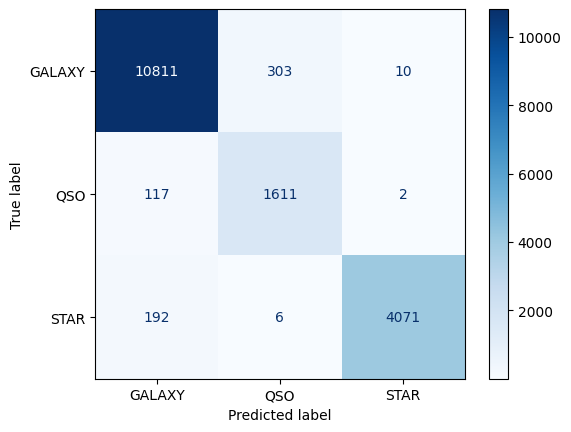

In [4]:
svc_holdout = SVC()
svc_holdout.fit(star_x_train, star_y_train)
evaluate_classification_model(svc_holdout, star_x_test, star_y_test)

#### Train an SVM classifier using cross-validation

Next, we can train an SVM classifier using cross-validation to get a better estimate of the model's performance, and calculate the mean accuracy and standard deviation of the model's performance across the folds

In [16]:
svc_cv = SVC()
svc_cv_scores = cross_val_score(svc_cv, star_X, star_Y, scoring='accuracy', n_jobs=-1)
print(f'Mean accuracy: {svc_cv_scores.mean()}')
print(f'Standard deviation: {svc_cv_scores.std()}')

Mean accuracy: 0.9644096152996191
Standard deviation: 0.0008522282547938581


#### Perform SVM classifier hyperparameter tuning

In [ ]:
svc_param_grid = {
#     'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
#     'degree': [2, 3],
#     'gamma': ['scale', 'auto', 0.1, 1, 10, 100]
}

svc_grid_search = GridSearchCV(SVC(), svc_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [9]:
svc_grid_search.fit(star_X, star_Y)

print(f'Best Parameters:')
for k, v in svc_grid_search.best_params_.items():
    print(f'{k} = {v}')

In [ ]:
svc_tuned = SVC(**svc_grid_search.best_params_)
svc_tuned_scores = cross_val_score(svc_tuned, star_X, star_Y, scoring='accuracy', cv=10, n_jobs=-1)

In [ ]:
svc_tuned.fit(star_x_train, star_y_train)
evaluate_classification_model(svc_tuned, star_x_test, star_y_test)

## GWP Dataset

In [3]:
gwp_X, gwp_Y = preprocess_gwp_dataset('datasets/gwp_assessment.csv')

#### Train a Random Forest Regressor using the holdout method

First let's split the dataset into training and test sets

In [4]:
gwp_x_train, gwp_x_test, gwp_y_train, gwp_y_test = train_test_split(gwp_X, gwp_Y, test_size=0.2)

Then we can train a Random Forest Regressor using the training set and evaluate it using the test set

R^2 Score: 0.2194596854003137
Mean Absolute Error: 0.08185391097715311
Root Mean Squared Error: 0.13340712717205105


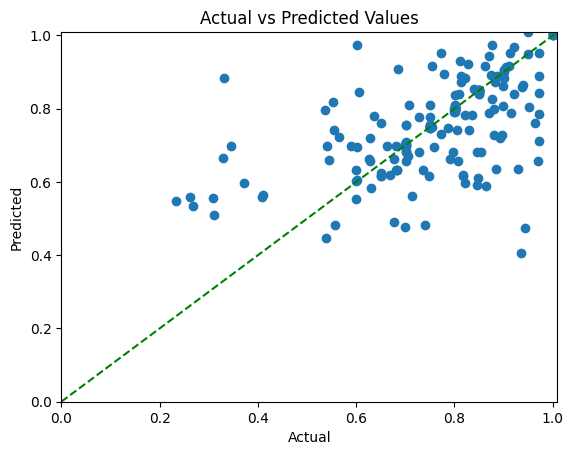

In [7]:
rf_holdout = RandomForestRegressor()
rf_holdout.fit(gwp_x_train, gwp_y_train)
evaluate_regression_model(rf_holdout, gwp_x_test, gwp_y_test)

#### Train a Random Forest Regressor using cross-validation

Next, we can train a Random Forest Regressor using cross-validation to get a better estimate of the model's performance, and calculate the mean R^2 score and standard deviation of the model's performance across the folds

In [8]:
rf_cv = RandomForestRegressor()
rf_cv_scores = cross_val_score(rf_cv, gwp_X, gwp_Y, scoring='r2', n_jobs=-1, cv=10)
print(f'Mean R^2 score: {rf_cv_scores.mean()}')
print(f'Standard deviation: {rf_cv_scores.std()}')

Mean R^2 score: 0.23486982133282286
Standard deviation: 0.11480174904658474


#### Perform Random Forest Regression hyperparameter tuning

In [9]:
rf_param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_grid_search = GridSearchCV(RandomForestRegressor(), rf_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

In [10]:
rf_grid_search.fit(gwp_X, gwp_Y)

print(f'Best Parameters:')
for k, v in rf_grid_search.best_params_.items():
    print(f'{k} = {v}')

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Parameters:
bootstrap = True
max_depth = 20
min_samples_leaf = 4
min_samples_split = 2
n_estimators = 50


R^2 Score: 0.26331494355384066
Mean Absolute Error: 0.08038644654786174
Root Mean Squared Error: 0.12960516003369268


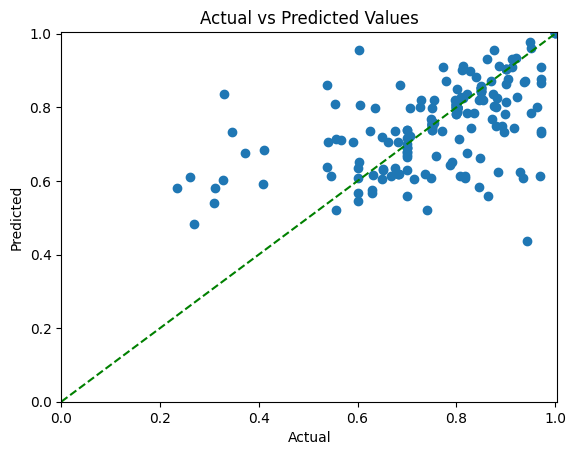

In [11]:
rf_tuned = RandomForestRegressor(**rf_grid_search.best_params_)
rf_tuned.fit(gwp_x_train, gwp_y_train)
evaluate_regression_model(rf_tuned, gwp_x_test, gwp_y_test)

## Markdown Question

*Is Linear Regression a good model to use for the star dataset? Justify your answer.*

Linear regression models assume a linear relationship between the features and the target variable, which isn't true in the case of many classification problems. In the star dataset, the target variable is categorical, namely having the classes `galaxy`, `qso` and `star`, meaning it is suited to be a classification task. Therefore, linear regression isn't a suitable model to use for this dataset, as there may not be a linear relationship between the features and the target. Additionally, using a linear regression model for the star dataset may result in predictions being made that don't fall into any of the three categories, making the predictions harder to interpret (and in certain cases, meaningless). Another reason why they shouldn't be used is that evaluation metrics commonly used for regression models, such as RMSE, are not suitable to be used for classification tasks, which use other metrics, including accuracy and F1-score. Finally, linear regression models are more sensitive to outliers than those suited to classification, which may result in the model being less accurate than a classification model.